In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/MyDrive/Lalith/cv_dataset/train'
val_dir = '/content/drive/MyDrive/Lalith/cv_dataset/val'
test_dir = '/content/drive/MyDrive/Lalith/cv_dataset/test'


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the data generators with rescaling
datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators for training, validation, and testing
train_generator = datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='input'
)

val_generator = datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='input'
)

test_generator = datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='input'
)


Found 465 images belonging to 1 classes.
Found 41 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


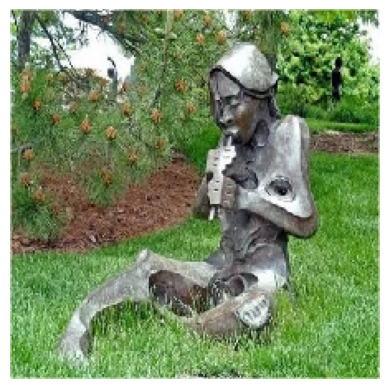

In [ ]:
import matplotlib.pyplot as plt

# Display a batch of images from the training set
batch = next(train_generator)
plt.imshow(batch[0][0])  # Show the first image in the batch
plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras import layers, models

def create_sr_model(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)

    # Basic super-resolution CNN layers
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output layer

    model = models.Model(inputs, x)
    return model

# Create the model instance
sr_model = create_sr_model()
sr_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,379 (302.26 KB)

 Trainable params: 77,379 (302.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Load VGG19 without the top layer, pretrained on ImageNet
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Select a specific layer for perceptual loss (e.g., 'block4_conv4')
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block4_conv4').output)
vgg_model.trainable = False  # Freeze VGG19


In [ ]:
def perceptual_loss(y_true, y_pred):
    y_pred_resized = tf.image.resize(y_pred, (224, 224))
    y_true_resized = tf.image.resize(y_true, (224, 224))
    y_true_features = vgg_model(y_true_resized)
    y_pred_features = vgg_model(y_pred_resized)
    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))


In [ ]:
sr_model.compile(optimizer='adam', loss=perceptual_loss, metrics=['mse'])


In [ ]:
batch_size = 32
steps_per_epoch = len(train_generator)  # Calculate based on generator size
validation_steps = len(val_generator)   # Calculate based on generator size


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
import tensorflow as tf

# Load VGG19 for perceptual loss
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block4_conv4').output)
vgg_model.trainable = False

# Define perceptual loss
def perceptual_loss(y_true, y_pred):
    y_true_features = vgg_model(y_true)
    y_pred_features = vgg_model(y_pred)
    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

# Compile sr_model with perceptual loss
sr_model.compile(optimizer='adam', loss=perceptual_loss, metrics=['mse'])


In [ ]:
batch = next(train_generator)
print(batch[0].shape)  # Should print something like (32, 224, 224, 3) for batch size 32


(32, 224, 224, 3)


In [ ]:
from PIL import Image
import os

# Convert images to RGB if they have transparency issues and log changes
for folder in [train_dir, val_dir, test_dir]:
    for root, _, files in os.walk(folder):
        for filename in files:
            img_path = os.path.join(root, filename)
            try:
                with Image.open(img_path) as img:
                    if img.mode != 'RGB':
                        img = img.convert("RGB")
                        img.save(img_path)
                        print(f"Converted {img_path} to RGB")
            except Exception as e:
                print(f"Error processing {img_path}: {e}")


In [ ]:
history = sr_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 977ms/step - loss: 6.6576 - mse: 0.1108 - val_loss: 2.8609 - val_mse: 0.1549
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 813ms/step - loss: 2.9012 - mse: 0.1899 - val_loss: 1.9351 - val_mse: 0.1729
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 838ms/step - loss: 2.1879 - mse: 0.1780 - val_loss: 1.6879 - val_mse: 0.1382
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 846ms/step - loss: 1.8455 - mse: 0.1273 - val_loss: 1.4775 - val_mse: 0.0873
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 818ms/step - loss: 1.6514 - mse: 0.0859 - val_loss: 1.1323 - val_mse: 0.0393
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 840ms/step - loss: 1.2054 - mse: 0.0355 - val_loss: 0.7639 - val_mse: 0.0167
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 816ms/step - loss: 0.7843 - mse: 0.0192 - val_loss: 0.5179 - val_mse: 0.0145
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 803ms/step - loss: 0.5856 - mse: 0.0185 - val_loss: 0.4312 - val_mse: 0.0126
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 826ms/

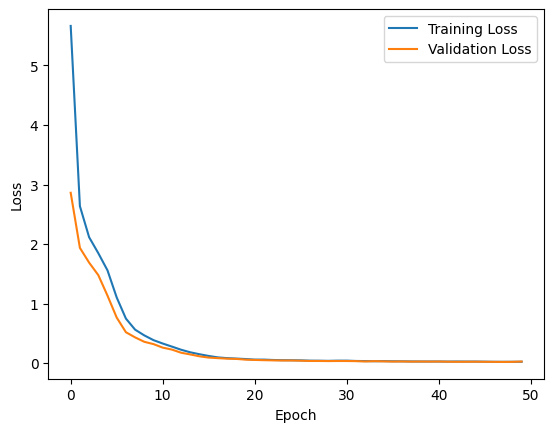

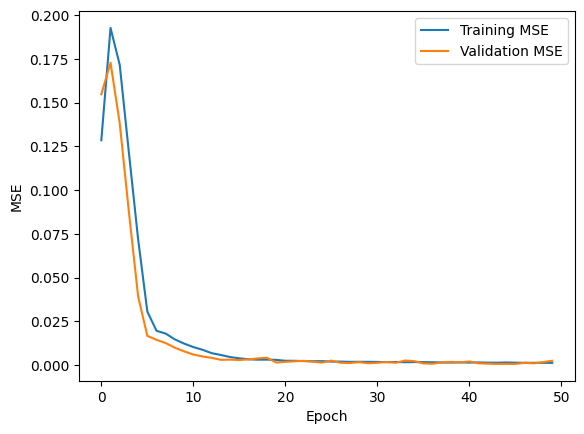

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation MSE
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [ ]:
test_loss, test_mse = sr_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}, Test MSE: {test_mse}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0288 - mse: 0.0031
Test Loss: 0.028842534869909286, Test MSE: 0.003077416680753231


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


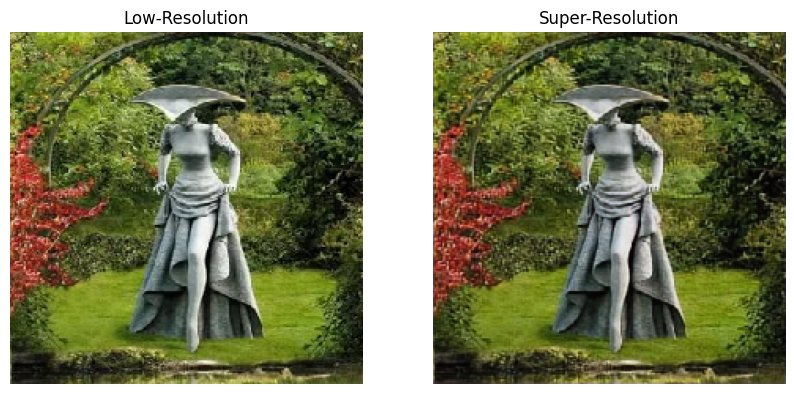

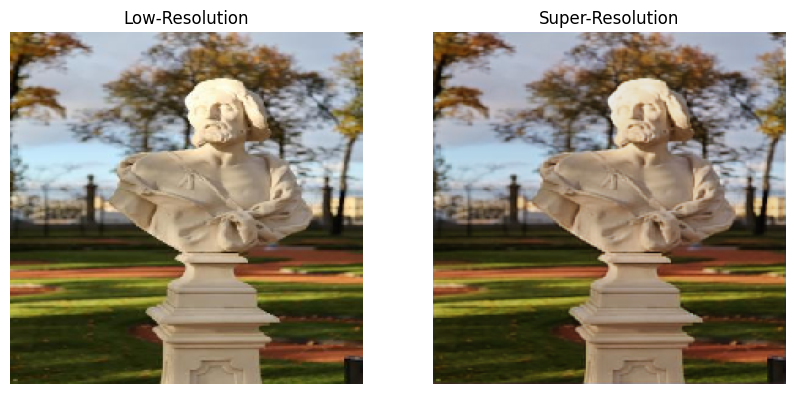

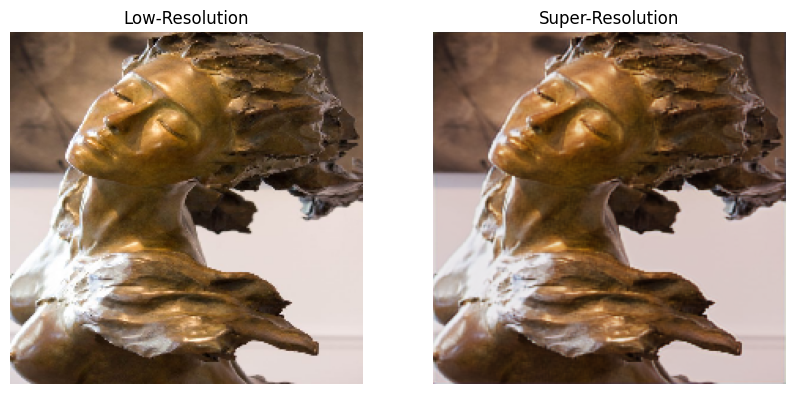

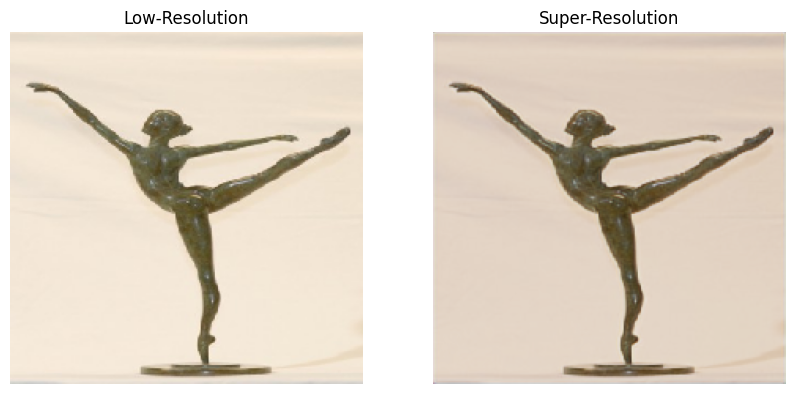

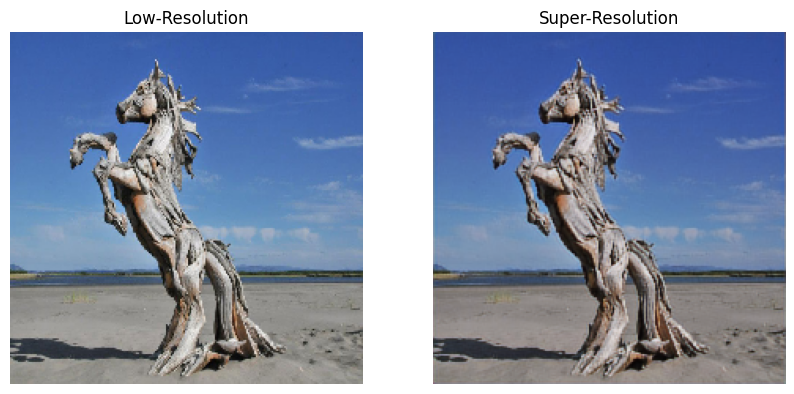

In [ ]:
import numpy as np

# Get a batch of test images
test_batch = next(test_generator)
low_res_images = test_batch[0]  # Low-resolution inputs

# Predict high-resolution images
sr_images = sr_model.predict(low_res_images)

# Display low-resolution and super-resolution images side by side
for i in range(5):  # Display first 5 images in the batch
    plt.figure(figsize=(10, 5))

    # Low-resolution image
    plt.subplot(1, 2, 1)
    plt.title("Low-Resolution")
    plt.imshow(np.clip(low_res_images[i], 0, 1))
    plt.axis('off')

    # Super-resolution image
    plt.subplot(1, 2, 2)
    plt.title("Super-Resolution")
    plt.imshow(np.clip(sr_images[i], 0, 1))
    plt.axis('off')

    plt.show()


In [33]:
sr_model.save('/content/drive/MyDrive/super_resolution_model.h5')


In [35]:
#peak signal to noise ratio
import tensorflow as tf

def calculate_psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)  # Assume pixel values are normalized [0,1]

# Example on a batch of test images
test_batch = next(test_generator)
low_res_images, high_res_images = test_batch  # Get low-res and high-res images
sr_images = sr_model.predict(low_res_images)  # Get super-res images

# Calculate PSNR for each image in the batch and average them
psnr_values = [calculate_psnr(high_res_images[i], sr_images[i]) for i in range(len(sr_images))]
avg_psnr = tf.reduce_mean(psnr_values)
print(f"Average PSNR on test set: {avg_psnr:.2f} dB")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Average PSNR on test set: 25.44 dB


In [36]:
#structural similarity index
def calculate_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)  # Assume pixel values are normalized [0,1]

# Calculate SSIM for each image in the batch and average them
ssim_values = [calculate_ssim(high_res_images[i], sr_images[i]) for i in range(len(sr_images))]
avg_ssim = tf.reduce_mean(ssim_values)
print(f"Average SSIM on test set: {avg_ssim:.4f}")


Average SSIM on test set: 0.9687


Perceptual Loss

In [37]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Load VGG19 and set it up for feature extraction
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Choose an intermediate layer for perceptual similarity (e.g., 'block4_conv4')
feature_layer = 'block4_conv4'
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer(feature_layer).output)
vgg_model.trainable = False  # Freeze the VGG model


In [38]:
import tensorflow as tf

def perceptual_loss(y_true, y_pred):
    # Extract features of the true and predicted images
    y_true_features = vgg_model(y_true)
    y_pred_features = vgg_model(y_pred)

    # Calculate the mean squared error between the features
    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))


In [39]:
# Get a batch of test images
test_batch = next(test_generator)
low_res_images, high_res_images = test_batch  # Low-res inputs and high-res targets

# Generate super-resolution images
sr_images = sr_model.predict(low_res_images)

# Calculate perceptual loss for each image pair in the batch
perceptual_losses = [perceptual_loss(tf.expand_dims(high_res_images[i], 0),
                                     tf.expand_dims(sr_images[i], 0)) for i in range(len(sr_images))]

# Average perceptual loss over the batch
avg_perceptual_loss = tf.reduce_mean(perceptual_losses)
print(f"Average Perceptual Loss on test set: {avg_perceptual_loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Average Perceptual Loss on test set: 0.0288


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


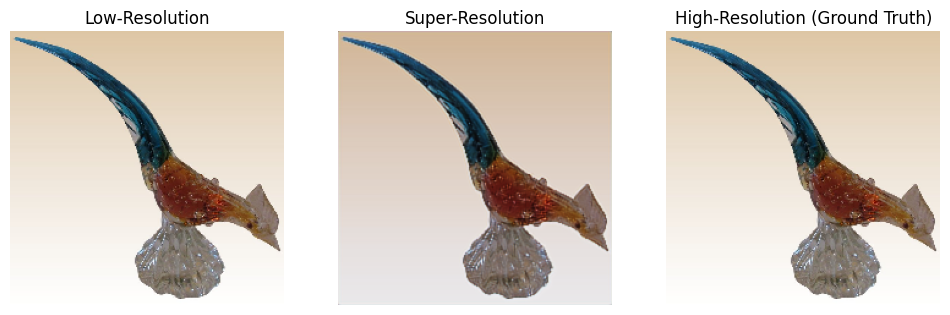

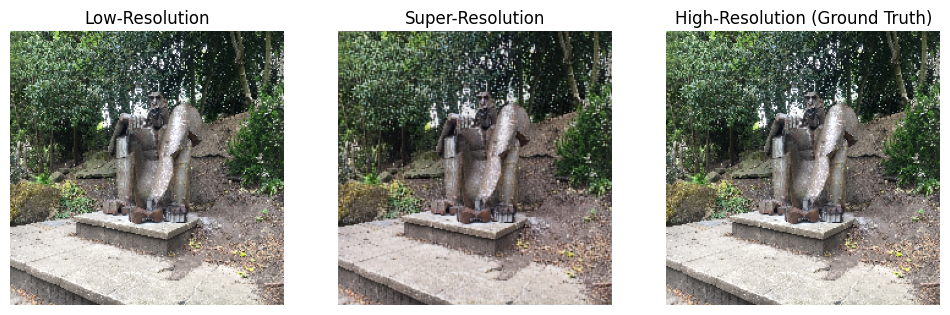

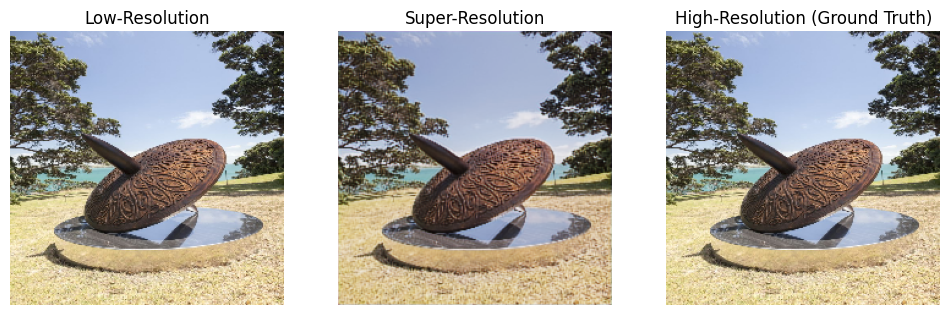

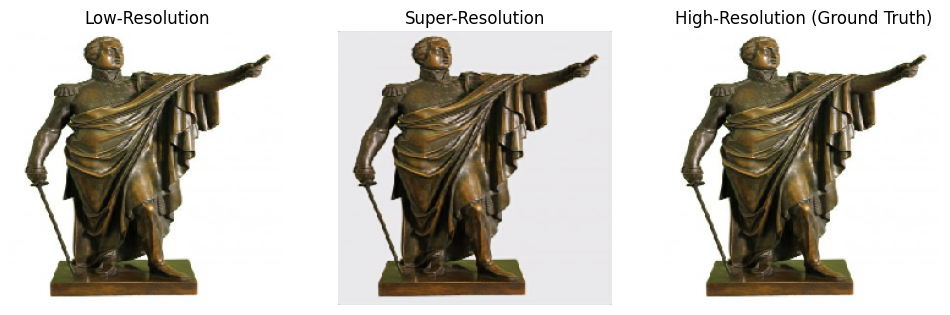

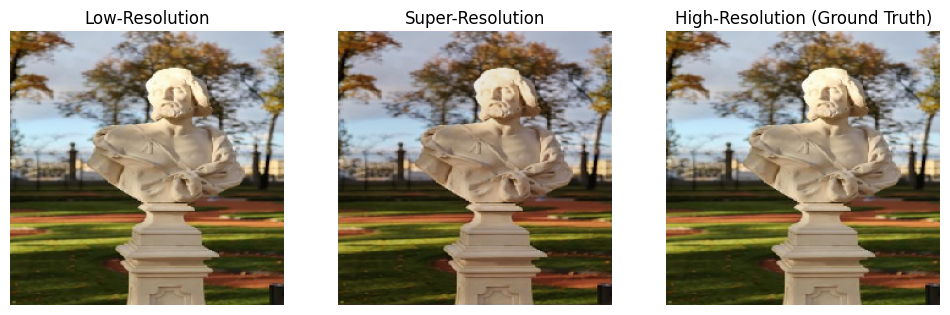

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of test images
test_batch = next(test_generator)
low_res_images, high_res_images = test_batch  # Low-res inputs and high-res targets
sr_images = sr_model.predict(low_res_images)  # Generate super-resolved images

# Display a few examples
num_examples = 5  # Number of examples to display
for i in range(num_examples):
    plt.figure(figsize=(12, 4))

    # Low-resolution input
    plt.subplot(1, 3, 1)
    plt.title("Low-Resolution")
    plt.imshow(np.clip(low_res_images[i], 0, 1))
    plt.axis('off')

    # Super-resolution output
    plt.subplot(1, 3, 2)
    plt.title("Super-Resolution")
    plt.imshow(np.clip(sr_images[i], 0, 1))
    plt.axis('off')

    # Ground-truth high-resolution
    plt.subplot(1, 3, 3)
    plt.title("High-Resolution (Ground Truth)")
    plt.imshow(np.clip(high_res_images[i], 0, 1))
    plt.axis('off')

    plt.show()


In [41]:
import tensorflow as tf

def calculate_psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)  # Assuming pixel values are in [0, 1]

# Calculate PSNR for each image in the test batch and get the average
psnr_values = [calculate_psnr(high_res_images[i], sr_images[i]) for i in range(len(sr_images))]
avg_psnr = tf.reduce_mean(psnr_values)
print(f"Average PSNR on test set: {avg_psnr:.2f} dB")


Average PSNR on test set: 25.44 dB


In [42]:
def calculate_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)  # Assuming pixel values are in [0, 1]

# Calculate SSIM for each image in the test batch and get the average
ssim_values = [calculate_ssim(high_res_images[i], sr_images[i]) for i in range(len(sr_images))]
avg_ssim = tf.reduce_mean(ssim_values)
print(f"Average SSIM on test set: {avg_ssim:.4f}")


Average SSIM on test set: 0.9687
